# Building and training GAN to generate anime faces

In this project I'm going to use Anime faces dataset to build and train Generative Adversarial Network capable of drawing anime faces.

### Downloading python packages.

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import Adam
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torchvision.utils as vutils
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.nn import ConvTranspose2d
from torch.nn import BatchNorm2d
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import LeakyReLU
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sigmoid
from torch import flatten
from imutils import build_montages
from torch.nn import BCELoss
import cv2

### Downloading and unpacking dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir "/content/dataset"
!unzip -d "/content/dataset" "/content/gdrive/MyDrive/anime.zip"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/dataset/images/62764_2019.jpg  
  inflating: /content/dataset/images/62765_2019.jpg  
  inflating: /content/dataset/images/62766_2019.jpg  
  inflating: /content/dataset/images/62767_2019.jpg  
  inflating: /content/dataset/images/62768_2019.jpg  
  inflating: /content/dataset/images/62769_2019.jpg  
  inflating: /content/dataset/images/6276_2003.jpg  
  inflating: /content/dataset/images/62770_2019.jpg  
  inflating: /content/dataset/images/62771_2019.jpg  
  inflating: /content/dataset/images/62772_2019.jpg  
  inflating: /content/dataset/images/62773_2019.jpg  
  inflating: /content/dataset/images/62774_2019.jpg  
  inflating: /content/dataset/images/62775_2019.jpg  
  inflating: /content/dataset/images/62776_2019.jpg  
  inflating: /content/dataset/images/62777_2019.jpg  
  inflating: /content/dataset/images/62778_2019.jpg  
  inflating: /content/dataset/images/62779_2019.jpg  
  inflating: /c

### Setting some of configurations for future work.

In [ ]:
# Root directory for dataset
dataroot = "/content/dataset"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of epochs
epochs = 50

Let's take a look at pictures in our dataset.

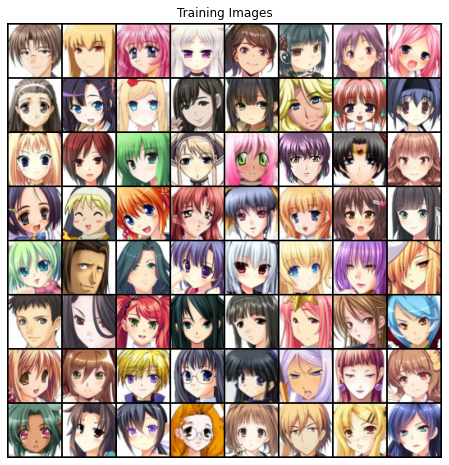

In [ ]:
# Loading and transforming dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=True)

# Device
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Building Generator

In [ ]:
class Generator(nn.Module):

    def __init__(self, inputDim=128, outputChannels=3):
      
      super(Generator, self).__init__()

      self.ct1 = ConvTranspose2d(in_channels=inputDim,
        out_channels=512, kernel_size=4, stride=1, padding=0,
        bias=False)
      self.batchNorm1 = BatchNorm2d(512)
      self.relu1 = ReLU(True)
 
      self.ct2 = ConvTranspose2d(in_channels=512, out_channels=256,
            kernel_size=4, stride=2, padding=1, bias=False)
      self.batchNorm2 = BatchNorm2d(256)
      self.relu2 = ReLU(True)

      self.ct3 = ConvTranspose2d(in_channels=256, out_channels=128,
            kernel_size=4, stride=2, padding=1, bias=False)
      self.batchNorm3 = BatchNorm2d(128)
      self.relu3 = ReLU(True)
      
      self.ct4 = ConvTranspose2d(in_channels=128, out_channels=64,
            kernel_size=4, stride=2, padding=1, bias=False)
      self.batchNorm4 = BatchNorm2d(64)
      self.relu4 = ReLU(True)

      self.ct5 = ConvTranspose2d(in_channels=64,
        out_channels=outputChannels, kernel_size=4, stride=2,
        padding=1, bias=False)
      self.tanh = Tanh()
    
    def forward(self, x):

        x = self.ct1(x)
        x = self.batchNorm1(x)
        x = self.relu1(x)

        x = self.ct2(x)
        x = self.batchNorm2(x) 
        x = self.relu2(x)

        x = self.ct3(x)
        x = self.batchNorm3(x)
        x = self.relu3(x)

        x = self.ct4(x)
        x = self.batchNorm4(x)
        x = self.relu4(x)

        x = self.ct5(x)
        output = self.tanh(x)

        return output

### Building Discriminator

In [ ]:
class Discriminator(nn.Module):

  def __init__(self, depth, alpha=0.2):

      super(Discriminator, self).__init__()

      self.conv1 = Conv2d(in_channels=depth, out_channels=64,
          kernel_size=4, stride=2, padding=1, bias=False)
      self.norm1 = BatchNorm2d(64)
      self.leakyRelu1 = LeakyReLU(alpha, inplace=True)

      self.conv2 = Conv2d(in_channels=64, out_channels=128, kernel_size=4,
          stride=2, padding=1, bias=False)
      self.norm2 = BatchNorm2d(128)
      self.leakyRelu2 = LeakyReLU(alpha, inplace=True)

      self.conv3 = Conv2d(in_channels=128, out_channels=256, kernel_size=4,
          stride=2, padding=1, bias=False)
      self.norm3 = BatchNorm2d(256)
      self.leakyRelu3 = LeakyReLU(alpha, inplace=True)

      self.conv4 = Conv2d(in_channels=256, out_channels=512, kernel_size=4,
          stride=2, padding=1, bias=False)
      self.norm4 = BatchNorm2d(512)
      self.leakyRelu4 = LeakyReLU(alpha, inplace=True)

      self.conv5 = Conv2d(in_channels=512, out_channels=1, kernel_size=4,
          stride=2, padding=0, bias=False)
      
      self.sigmoid = Sigmoid()
    
  def forward(self, x):

      x = self.conv1(x)
      x = self.norm1(x)
      x = self.leakyRelu1(x)

      x = self.conv2(x)
      x = self.norm2(x)
      x = self.leakyRelu2(x)

      x = self.conv3(x)
      x = self.norm3(x)
      x = self.leakyRelu3(x)

      x = self.conv4(x)
      x = self.norm4(x)
      x = self.leakyRelu4(x)

      x = self.conv5(x)

      x = flatten(x, 1)
      output = self.sigmoid(x)

      return output

### Initializing custom weights called on generator and discriminator

In [ ]:
def weights_init(model):

	classname = model.__class__.__name__

	if classname.find("Conv") != -1:
		nn.init.normal_(model.weight.data, 0.0, 0.02)

	elif classname.find("BatchNorm") != -1:
		nn.init.normal_(model.weight.data, 1.0, 0.02)
		nn.init.constant_(model.bias.data, 0)

### Building Generator and Discriminator on used device (cpu or cuda). Initiating oprimizer and loss function.

In [ ]:
# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Steps per epoch
stepsPerEpoch = len(dataloader.dataset) // batch_size

# Build generator
print("[INFO] building generator...")
gen = Generator(inputDim=100, outputChannels=3)
gen.apply(weights_init)
gen.to(DEVICE)

# Build discriminator
print("[INFO] building discriminator...")
disc = Discriminator(depth=3)
disc.apply(weights_init)
disc.to(DEVICE)

# Set optimizer
genOpt = Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999),
	weight_decay=0.0002 / epochs)
discOpt = Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999),
	weight_decay=0.0002 / epochs)

# Set loss function
criterion = BCELoss()

[INFO] building generator...
[INFO] building discriminator...


### Training Generator and Discriminator. Saving generated images.

In [ ]:
# Randomly generate some benchmark noise to visualize how the generative modeling is learning
print("[INFO] starting training...")
benchmarkNoise = torch.randn(256, 100, 1, 1, device=DEVICE)

# Real and fake label values
realLabel = 1
fakeLabel = 0

# Looping over epochs
for epoch in range(epochs):
    # Showing epoch number
    print("[INFO] starting epoch {} of {}...".format(epoch + 1,
      epochs))
    
    # Initializing current epoch loss for Generator and Discriminator
    epochLossG = 0
    epochLossD = 0

    for x in dataloader:
        # Zeroing out the Discriminator gradients
        disc.zero_grad()

        # Grabbing the images and sending them to the device
        images = x[0]
        images = images.to(DEVICE)

        # Getting the batch size and creating a labels tensor
        bs =  images.size(0)
        labels = torch.full((bs,), realLabel, dtype=torch.float,
          device=DEVICE)
        
        # Forward pass through discriminator
        output = disc(images).view(-1)

        # Calculating the loss on all-real batch
        errorReal = criterion(output, labels)

        # Calculating gradients with a backward pass
        errorReal.backward()

        # Generating random noise for the generator to predict on
        noise = torch.randn(bs, 100, 1, 1, device=DEVICE)

        # Generating a fake image batch with the Generator
        fake = gen(noise)
        labels.fill_(fakeLabel)

        # Forward pass through discriminator using fake batch data
        output = disc(fake.detach()).view(-1)
        errorFake = criterion(output, labels)

        # Calculatung gradients with a backward pass
        errorFake.backward()

        # Computing the error for Discriminator and updatu=ing it
        errorD = errorReal + errorFake
        discOpt.step()

        # Setting all Generator gradients to zero
        gen.zero_grad()

        # Updating the labels as fake labels are real for the Generator
        # Forward pass of fake data through Discriminator
        labels.fill_(realLabel)
        output = disc(fake).view(-1)

        # Calculating Generator's loss based on output from
        # Discriminator and calculating gradients for Generator
        errorG = criterion(output, labels)
        errorG.backward()

        # Updating the Generator
        genOpt.step()

        # Saving current iteration's loss of Discriminator and Generator
        epochLossD += errorD
        epochLossG += errorG

    # Training information
    print("[INFO] Generator Loss: {:.4f}, Discriminator Loss: {:.4f}".format(
      epochLossG / stepsPerEpoch, epochLossD / stepsPerEpoch))
    
    # Saving the output of the Generator
    if (epoch + 1) % 2 == 0:
      # Setting Generator into evaluation phase, making predictions on
      # the benchmark noise, scaling it back to the range [0, 255],
      # and generating the montage
      gen.eval()
      images = gen(benchmarkNoise)
      images = images.detach().cpu().numpy().transpose((0, 2, 3, 1))
      images = ((images * 127.5) + 127.5).astype("uint8")
      images = np.repeat(images, 1, axis=-1)
      vis = build_montages(images, (100, 100), (5, 5))[0]

      # Writing the visualization to disk
      p = os.path.join("output", "epoch_{}.png".format(
        str(epoch + 1).zfill(4)))
      cv2.imwrite("/content/gdrive/MyDrive/Runs/deffochka_{}.png".format(epoch), vis)
      
      # Setting Generator to training mode
      gen.train()

[INFO] starting training...
[INFO] starting epoch 1 of 50...
[INFO] Generator Loss: 8.1952, Discriminator Loss: 0.7308
[INFO] starting epoch 2 of 50...
[INFO] Generator Loss: 5.6533, Discriminator Loss: 0.6988
[INFO] starting epoch 3 of 50...
[INFO] Generator Loss: 5.4373, Discriminator Loss: 0.5704
[INFO] starting epoch 4 of 50...
[INFO] Generator Loss: 5.6094, Discriminator Loss: 0.5257
[INFO] starting epoch 5 of 50...
[INFO] Generator Loss: 5.1986, Discriminator Loss: 0.5056
[INFO] starting epoch 6 of 50...
[INFO] Generator Loss: 5.0292, Discriminator Loss: 0.5485
[INFO] starting epoch 7 of 50...
[INFO] Generator Loss: 4.8557, Discriminator Loss: 0.5229
[INFO] starting epoch 8 of 50...
[INFO] Generator Loss: 4.4907, Discriminator Loss: 0.5455
[INFO] starting epoch 9 of 50...
[INFO] Generator Loss: 4.2281, Discriminator Loss: 0.5749
[INFO] starting epoch 10 of 50...
[INFO] Generator Loss: 3.9039, Discriminator Loss: 0.5866
[INFO] starting epoch 11 of 50...
[INFO] Generator Loss: 3.73

# Checking the result

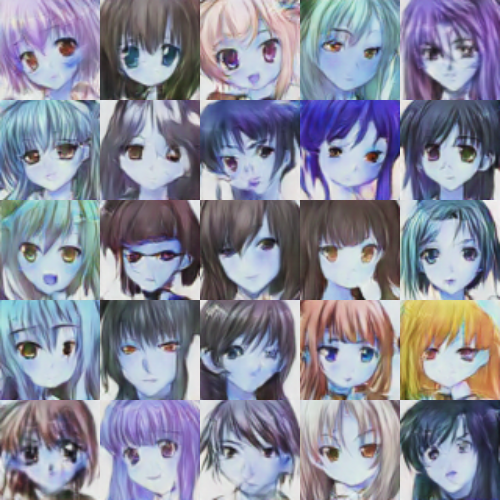

In [ ]:
from IPython.display import Image
Image('/content/gdrive/MyDrive/Runs/deffochka_49.png')